To download this notebook, click the download icon in the toolbar above and select the .ipynb format.

# Ballistic Coefficient Estimation with Extended Kalman Filter 

The following example appears in several sources. 
[ZP]_ provides a great deal of detail. Additional sources can be found in [SD]_. 


The problem is to estimate the ballistic coefficient of a target 
in a free fall where a noisy radar is tracking it.


The mathematical background required for understanding the Extended Kalman Filter and the form of implementation using c4dynamics is found in [the introduction page to the filters module documentary](https://c4dynamics.github.io/C4dynamics/api/Filters.html#extended-kalman-filter-ekf). 

The `ekf` class of c4dynamics is found [here](https://c4dynamics.github.io/C4dynamics/api/filters.ekf.html#c4dynamics.filters.ekf.ekf). 

The program utilizes the following components of c4dynamics: 


| Object  | Module    | Description |
|---------|-----------|-------------|
| target  | [state](https://c4dynamics.github.io/C4dynamics/api/states.state.html) | The target is a state object of three variables (altitude, vertical velocity, ballistic coefficient) |
| radar   | [radar](https://c4dynamics.github.io/C4dynamics/api/sensors.radar.html)   | Range detector 
| ekf     | [ekf](https://c4dynamics.github.io/C4dynamics/api/filters.ekf.html)     | Extended Kalman filter with three variables state (altitude, vertical velocity, ballistic coefficient) | 
| g_fts2     | [const](https://c4dynamics.github.io/C4dynamics/api/utils.const.html)     | Gravity constant in foot per seconds squared |
| plotdefaults | [utils](https://c4dynamics.github.io/C4dynamics/api/generated/utils/c4dynamics.utils.plottools.plotdefaults.html) | Setting default properties on a matplotlib axis |



The process equations are: 


$$\dot{z} = v_z$$  
$$\dot{v}_z = {\rho_0 \cdot e^{-z / k} \cdot v_z^2 \cdot g \over 2 \cdot \beta} - g$$  
$$\dot{\beta} = \omega_{\beta}$$  

With output measure: 

$$y = z + \nu_k$$


Where:
- $z$ is the target altitude ($ft$)
- $v_z$ is the target vertical velocity ($ft/s$)
- $\beta$ is the target ballistic coefficient ($lb/ft^2$)
- $y$ is the system measure 
- $\rho_{0} = 0.0034$
- $k = 22,000$ 
- $g = 32.2 ft/s^2$
- $\omega_{\beta} \sim (0, 300)$
- $\nu_k \sim (0, 500)$ 

These equations represent the motion of the target in a free fall in the presence of air resistance which modifies the aerodynamic drag coefficient of the target.  
The first variable, z, is simply the target altitude. It's derivative is the vertical velocity $v_z$.  
The derivative of $v_z$ is the vertical acceleration given by the difference between the acceleration due to gravity and aerodynamic force divided by the target mass. 


Let:



$$
  \rho = \rho_0 \cdot e^{-z / k}
$$



The lineariztion of the process matrix for the `predict` step:



$$
  M = \begin{bmatrix}
        0 & 1 & 0 \\
          -\rho \cdot g \cdot v_z^2 / (44000 \cdot \beta) 
          & \rho \cdot g \cdot v_z / \beta
          & -\rho \cdot g \cdot v_z^2 \cdot / (2 \cdot \beta^2) \\ 
            0 & 0 & 0
      \end{bmatrix}  
$$
  


The measurement is a direct sample of the altitude of the target
so these equations are already a linear function of the state and represented by the matrix `H`: 


$$
  H = \begin{bmatrix}
        1 & 0 & 0 
      \end{bmatrix}  
$$              



We now have all we need to run the extended Kalman filter. 
      


In [7]:
import sys 
sys.path.append(f'..\..\..')
import c4dynamics as c4d
import numpy as np 
from scipy.integrate import odeint


Quick setup for an ideal case: 


In [4]:
dt, tf = .01, 30
tspan = np.arange(dt, tf, dt) 
dtsensor = 0.05  
rho0, k = 0.0034, 22000 
tgt = c4d.state(z = 100000, vz = -6000, beta = 500)
altmtr = c4d.sensors.radar(isideal = True, dt = dt)


Target equations of motion:


In [5]:
def ballistics(y, t):  
  return [y[1], rho0 * np.exp(-y[0] / k) * y[1]**2 * c4d.g_fts2 / 2 / y[2] - c4d.g_fts2, 0]

Main loop: 



In [8]:
for t in tspan:
  tgt.store(t)
  tgt.X = odeint(ballistics, tgt.X, [t, t + dt])[-1]
  _, _, z = altmtr.measure(tgt, t = t, store = True)

Let's write a plotting function that serves us to draw the results at each run of the filter.

The parameters of the function `drawekf` enable to control the elements of the components to draw: 
- `ekf`: estimated object
- `trueobj`: ground truth reference to the estimation 
- `measure`: the raw samples of the sensor 
- `std`: the square root of the covariance matrix `P`, representing one standard deviation of the estimation error


In [15]:
from matplotlib import pyplot as plt  
plt.style.use('dark_background')  

def drawekf(ekf = None, trueobj = None, measures = None, std = False, title = '', filename = None): 

  textsize = 10
  

  fig, ax = plt.subplots(1, 3, dpi = 200, figsize = (9, 3) 
                , gridspec_kw = {'left': .15, 'right': .95
                                  , 'top': .80, 'bottom': .15
                                    , 'hspace': 0.5, 'wspace': 0.4}) 

  fig.suptitle('                ' + title, fontsize = 14, fontname = 'Times New Roman')
  plt.subplots_adjust(top = 0.95) 


  ''' altitude '''

  if trueobj: 
    ax[0].plot(*trueobj.data('z'), 'm', linewidth = 1.2, label = 'true') 
  
  if measures: 
    ax[0].plot(*measures.data('range'), '.c', markersize = 1, label = 'altmeter')

  if ekf:
    ax[0].plot(*ekf.data('z'), linewidth = 1, color = 'y', label = 'ekf')

  if std: 
    x = ekf.data('z')[1]
    t_sig, x_sig = ekf.data('P00')
    # ±std 
    ax[0].plot(t_sig, x + np.sqrt(x_sig.squeeze()), linewidth = 1, color = 'w', label = 'std') # np.array(v.color) / 255)
    ax[0].plot(t_sig, x - np.sqrt(x_sig.squeeze()), linewidth = 1, color = 'w') # np.array(v.color) / 255)
 


  c4d.plotdefaults(ax[0], 'Altitude', 'Time [s]', 'ft', textsize)
  ax[0].legend(fontsize = 'xx-small', facecolor = None, framealpha = .5)  
  

  ''' velocity '''

  if trueobj: 
    ax[1].plot(*trueobj.data('vz'), 'm', linewidth = 1.2, label = 'true') 

  if ekf:
    ax[1].plot(*ekf.data('vz'), linewidth = 1, color = 'y', label = 'ekf')

  if std: 
    x = ekf.data('vz')[1]
    t_sig, x_sig = ekf.data('P11') 
    # ±std 
    ax[1].plot(t_sig, (x + np.sqrt(x_sig.squeeze())), linewidth = 1, color = 'w', label = 'std') # np.array(v.color) / 255)
    ax[1].plot(t_sig, (x - np.sqrt(x_sig.squeeze())), linewidth = 1, color = 'w') # np.array(v.color) / 255)

  c4d.plotdefaults(ax[1], 'Velocity', 'Time [s]', 'ft/s', textsize)




  ''' ballistic coefficient '''

  if trueobj: 
    ax[2].plot(*trueobj.data('beta'), 'm', linewidth = 1.2, label = 'true') # label = r'$\gamma$') #'\\gamma') # 

  if ekf:
    ax[2].plot(*ekf.data('beta'), linewidth = 1, color = 'y', label = 'ekf')

  if std: 
    x = ekf.data('beta')[1]
    t_sig, x_sig = ekf.data('P22')
    # ±std 
    ax[2].plot(t_sig, (x + np.sqrt(x_sig.squeeze())), linewidth = 1, color = 'w', label = 'std') # np.array(v.color) / 255)
    ax[2].plot(t_sig, (x - np.sqrt(x_sig.squeeze())), linewidth = 1, color = 'w') # np.array(v.color) / 255)


  c4d.plotdefaults(ax[2], 'Beta', 'Time [s]', 'lb/ft^2', textsize)


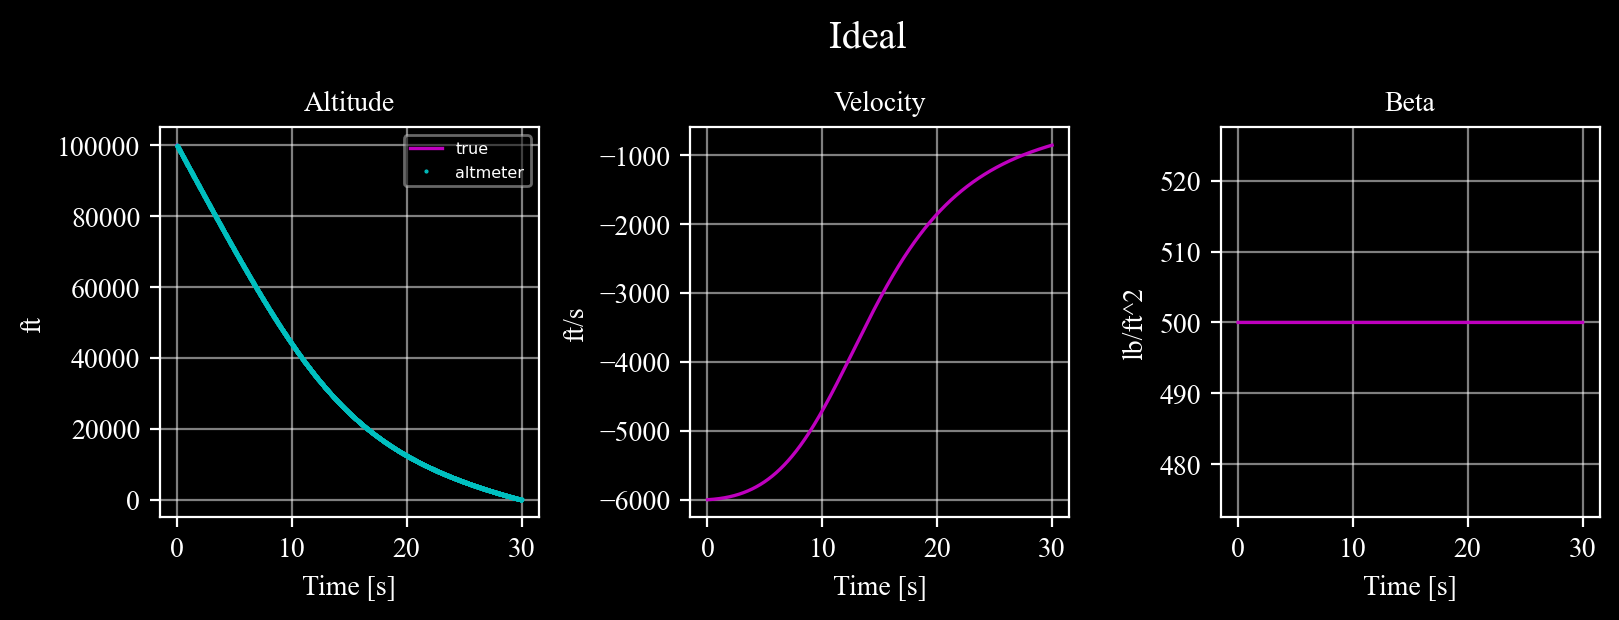

In [16]:
drawekf(trueobj = tgt, measures = altmtr, title = 'Ideal', filename = 'bal_ideal')



These figures show the time histories of the altitude, velocity, 
and ballistic coefficient, for a target in a free fall with ideal conditions. 

Let's examine the `ekf` capability to estimate $\beta$ at the presence of errors.  
Errors in initial conditions introduced into each one of the variables: 
$z_{0_{err}} = 25, v_{z_{0_{err}}} = -150, \\beta_{0_{err}} = 300$.  
The uncertainty in the ballistic coefficient is given in terms of 
the spectral density of a continuous system, such that for flight time $t_f$, 
the standard deviation of the ballistic coefficient noise 
is $\omega_{\beta} = \sqrt{\beta_{err} \cdot t_f}$. 
The measurement noise is $\nu = \sqrt{500}$. These use 
for the noise covariance matrices `Q, R` as for 
the initialization of the state covariance matrix `P`:   



In [17]:
zerr, vzerr, betaerr = 25, -150, 1000 
nu = np.sqrt(500) 
p0 = np.diag([nu**2, vzerr**2, betaerr**2])
R = nu**2 / dt
Q = np.diag([0, 0, betaerr**2 / tf * dt])  
# altmeter and ekf construction: 
altmtr = c4d.sensors.radar(rng_noise_std = nu, dt = dtsensor) 
ekf = c4d.filters.ekf(X = {'z': tgt.z + zerr, 'vz': tgt.vz + vzerr, 'beta': tgt.beta + betaerr}, P0 = p0, dt = dt) 

TypeError: ekf.__init__() got an unexpected keyword argument 'dt'



The main loop includes the simulation of the target motion, the linearization 
and discretization of the process equations, and calling the `predict` method. 
Then linearization and discretization of the measurement equations (not relevant 
here as the measurement is already linear), and calling the `update` method. 


In [ ]:
for t in tspan:
  # target motion simulation  
  tgt.X = odeint(ballistics, tgt.X, [t, t + dt])[-1]
  # process linearization 
  rhoexp = rho0 * np.exp(-ekf.z / k) * c4d.g_fts2 * ekf.vz / ekf.beta
  fx = [ekf.vz, rhoexp * ekf.vz / 2 - c4d.g_fts2, 0]
  f2i = rhoexp * np.array([-ekf.vz / 2 / k, 1, -ekf.vz / 2 / ekf.beta])
  # discretization 
  F = np.array([[0, 1, 0], f2i, [0, 0, 0]]) * dt + np.eye(3)
  # ekf predict 
  ekf.predict(F, Q, fx = fx)
  # take a measure 
  _, _, Z = altmtr.measure(tgt, t = t, store = True)
  if Z is not None:  
    H = [1, 0, 0]
    # ekf update 
    ekf.update(Z, H, R)
  # store states
  tgt.store(t)
  ekf.store(t)


Though the `update` requires also the linear 
process matrix (:math:`F`), the `predict` method 
stores the introduced `F` to prove that 
the `update` step always comes after calling the `predict`. 




![alt text](/_examples/filters/bal_filtered.png)


In [ ]:
# type: ignore

import numpy as np 
from scipy.integrate import odeint 

from matplotlib import pyplot as plt 
plt.style.use('dark_background')  
# plt.switch_backend('TkAgg')

import os, sys
sys.path.append(r'../../../')
print(os.getcwd())
import c4dynamics as c4d 


savedir = os.path.join(c4d.c4dir(os.getcwd()), 'docs', 'source', '_examples', 'filters') 


dt, tf =  0.01, 30 # .05, 30 #
tspan = np.arange(0, tf + dt, dt)  
dtsensor = .05 # 0.1 # 





rho0 = .0034 
k = 22000 
nu = np.sqrt(500) 
zerr, vzerr, betaerr = 25, -150, 300 

The equations of motion are governed by the ballistics() function

In [ ]:
def ballistics(y, t):

  # altitude 
  # velocity 
  # ballistic coefficient 
  return [y[1], rho0 * np.exp(-y[0] / k) * y[1]**2 * c4d.g_fts2 / 2 / y[2] - c4d.g_fts2, 0]

In [ ]:
def ideal():
  ''' ideal '''
  tgt = c4d.state(z = 100000, vz = -6000, beta = 500)
  altmtr = c4d.sensors.radar(isideal = True, dt = dtsensor)

  for t in tspan:
    tgt.store(t)
    
    tgt.X = odeint(ballistics, tgt.X, [t, t + dt])[-1]
    altmtr.measure(tgt, t = t, store = True)
    
  return tgt, altmtr


In [ ]:
def noisy():
  ''' noisy no kalman ''' 
  tgt = c4d.state(z = 100000, vz = -6000, beta = 500)
  altmtr = c4d.sensors.radar(rng_noise_std = nu, dt = dtsensor)

  for t in tspan:
    tgt.store(t)

    tgt.X = odeint(ballistics, tgt.X, [t, t + dt])[-1]
    altmtr.measure(tgt, t = t, store = True)

  return tgt, altmtr

In [ ]:
def filtered():
  ''' filtered ''' 
  tgt = c4d.state(z = 100000, vz = -6000, beta = 500)


  p0 = np.diag([nu**2, vzerr**2, betaerr**2]) # when a list is given the std are provided. when matrix the variances. 
  R = nu**2 / dt


  ''' sensor init '''
  altmtr = c4d.sensors.radar(rng_noise_std = nu, dt = dtsensor) 
  Q = np.diag([0, 0, betaerr**2 / tf * dt])  

  np.random.seed(1337)

  H = [1, 0, 0]
  ekf = c4d.filters.ekf(X = {'z': tgt.z + zerr, 'vz': tgt.vz + vzerr
                                  , 'beta': tgt.beta + betaerr}
                          , P0 = p0, H = H, Q = Q, R = R) 

  for t in tspan:

    ''' store the state '''
    tgt.store(t)
    ekf.store(t)

    tgt.X = odeint(ballistics, tgt.X, [t, t + dt])[-1]


    ''' 
    the necessary linear parameters for the predict stage: the 
    state transition matrix Phi (or its first order approximation F - the discreteized system matrix) 
    '''
    rhoexp  =   rho0 * np.exp(-ekf.z / k) * c4d.g_fts2 * ekf.vz / ekf.beta
    fx      =   [ekf.vz, rhoexp * ekf.vz / 2 - c4d.g_fts2, 0]
    f2i     =   rhoexp * np.array([-ekf.vz / 2 / k, 1, -ekf.vz / 2 / ekf.beta])
    F       =   np.array([[0, 1, 0], f2i, [0, 0, 0]]) * dt + np.eye(3)
    ekf.predict(F = F, fx = fx, dt = dt)


    ''' the necessary linear parameters for the predict stage: the measure matrix H '''
    _, _, Z = altmtr.measure(tgt, t = t, store = True)
    
    if Z is not None:  
      ekf.update(Z)

  return tgt, altmtr, ekf 

In [ ]:
tgt1, altmtr = ideal()
# drawekf(trueobj = tgt1, measures = altmtr, title = 'Ideal', filename = 'bal_ideal')

tgt2, altmtr = noisy()
# drawekf(trueobj = tgt2, measures = altmtr, title = 'Noisy')


tgt, altmtr, ekf = filtered()
drawekf(trueobj = tgt2, measures = altmtr, ekf =  ekf, title = 'Filtered', filename = 'bal_filtered')





A few steps to consider when designing a Kalman filter: 

- Spend some time understanding the dynamics. It's the basis of great filtering. 
- If the system is nonlinear, identify the nonlinearity; is it in the process? in the measurement? both? 
- Always prioriorotize linear Kalman. If possible, find a nominal trajectory to linearize the system about.
- The major time-consuming activity is researching the balance between the noise matrices `Q` and `R`.
- -> Plan your time in advance.
- Use a framework that provides you with the most flexibility and control.
- Make fun! 


